In [20]:
'''
File name: preprocessing.ipynb
Authors: Yasmin El Euch, Aliénor Bénédicte G Hamoir, Clara Rossignol, Guillaume David E. Ryelandt
Date created: 04/11/2022
Date last modified: 06/11/2022
Python version: 3.8.8
'''

'\nFile name: preprocessing.ipynb\nAuthors: Yasmin El Euch, Aliénor Bénédicte G Hamoir, Clara Rossignol, Guillaume David E. Ryelandt\nDate created: 04/11/2022\nDate last modified: 06/11/2022\nPython version: 3.8.8\n'

In [34]:
#Imports used in this notebook
from datetime import datetime

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [22]:
data_folder = 'data/'

In [23]:
print("Reading in movie data")

# Read in movie metadata and plot summaries
movie_headers = ['Wikipedia movie ID', 'Freebase movie ID', 'Movie name','Movie release date','Movie box office revenue',
                 'Movie runtime','Movie languages','Movie countries','Movie genres']
plot_headers = ['Wikipedia movie ID','Plot Summary']
character_headers = ['Wikipedia movie ID', 'Freebase movie ID','Movie release date','Character name','Actor date of birth',
                     'Actor gender','Actor height','Actor ethnicity','Actor name','Actor age at movie release',
                     'Freebase character/actor map ID','Freebase character ID','Freebase actor ID']

movie_metadata = pd.read_csv(data_folder + 'movie.metadata.tsv',sep='\t',header=None,names=movie_headers,index_col=0)
plot_summaries = pd.read_csv(data_folder + 'plot_summaries.txt',sep='\t',index_col=0,names=plot_headers)
character_metadata = pd.read_csv(data_folder + 'character.metadata.tsv',sep='\t',header=None,names=character_headers,index_col='Wikipedia movie ID')

Reading in movie data


In [51]:
movie_metadata_clean.head()

,Freebase movie ID,Movie name,Movie release date,Movie box office revenue,Movie runtime,Movie languages,Movie countries,Movie genres
Wikipedia movie ID,,,,,,,,
975900,/m/03vyhn,Ghosts of Mars,2001-08-24,14010832.0,98.0,"{""/m/02h40lc"": ""English Language""}","{""/m/09c7w0"": ""United States of America""}","{""/m/01jfsb"": ""Thriller"", ""/m/06n90"": ""Science..."
3196793,/m/08yl5d,Getting Away with Murder: The JonBenét Ramsey ...,2000-02-16,0.0,95.0,"{""/m/02h40lc"": ""English Language""}","{""/m/09c7w0"": ""United States of America""}","{""/m/02n4kr"": ""Mystery"", ""/m/03bxz7"": ""Biograp..."
28463795,/m/0crgdbh,Brun bitter,1988,0.0,83.0,"{""/m/05f_3"": ""Norwegian Language""}","{""/m/05b4w"": ""Norway""}","{""/m/0lsxr"": ""Crime Fiction"", ""/m/07s9rl0"": ""D..."
9363483,/m/0285_cd,White Of The Eye,1987,0.0,110.0,"{""/m/02h40lc"": ""English Language""}","{""/m/07ssc"": ""United Kingdom""}","{""/m/01jfsb"": ""Thriller"", ""/m/0glj9q"": ""Erotic..."
261236,/m/01mrr1,A Woman in Flames,1983,0.0,106.0,"{""/m/04306rv"": ""German Language""}","{""/m/0345h"": ""Germany""}","{""/m/07s9rl0"": ""Drama""}"


In [52]:
plot_summaries.head()

,Plot Summary
Wikipedia movie ID,
23890098,"Shlykov, a hard-working taxi driver and Lyosha..."
31186339,The nation of Panem consists of a wealthy Capi...
20663735,Poovalli Induchoodan is sentenced for six yea...
2231378,"The Lemon Drop Kid , a New York City swindler,..."
595909,Seventh-day Adventist Church pastor Michael Ch...


In [36]:
print("Movies with biggest box office revenues:")
movie_metadata.sort_values('Movie box office revenue', ascending = False).head()

Movies with biggest box office revenues:


,Freebase movie ID,Movie name,Movie release date,Movie box office revenue,Movie runtime,Movie languages,Movie countries,Movie genres
Wikipedia movie ID,,,,,,,,
4273140,/m/0bth54,Avatar,2009-12-10,2.782275e+09,178.0,"{""/m/02h40lc"": ""English Language"", ""/m/06nm1"":...","{""/m/09c7w0"": ""United States of America"", ""/m/...","{""/m/01jfsb"": ""Thriller"", ""/m/06n90"": ""Science..."
52371,/m/0dr_4,Titanic,1997-11-01,2.185372e+09,194.0,"{""/m/02bjrlw"": ""Italian Language"", ""/m/02h40lc...","{""/m/09c7w0"": ""United States of America""}","{""/m/0fx2s"": ""Tragedy"", ""/m/04xvh5"": ""Costume ..."
22114132,/m/062zm5h,The Avengers,2012-04-11,1.511758e+09,137.0,"{""/m/06b_j"": ""Russian Language"", ""/m/02h40lc"":...","{""/m/09c7w0"": ""United States of America""}","{""/m/06n90"": ""Science Fiction"", ""/m/02kdv5l"": ..."
31941988,/m/0gvsynb,Harry Potter and the Deathly Hallows – Part 2,2011-07-07,1.328111e+09,130.0,"{""/m/02h40lc"": ""English Language""}","{""/m/09c7w0"": ""United States of America"", ""/m/...","{""/m/07s9rl0"": ""Drama"", ""/m/02n4kr"": ""Mystery""..."
25001260,/m/0872p_c,Transformers: Dark of the Moon,2011-06-23,1.123747e+09,157.0,"{""/m/02h40lc"": ""English Language""}","{""/m/09c7w0"": ""United States of America""}","{""/m/0hj3mt0"": ""Alien Film"", ""/m/06n90"": ""Scie..."


In [ ]:
print("What is needed to be processed:")
print("Rows with actor age at movie release under or equal to 0: %d" %len(character_metadata[character_metadata['Actor age at movie release']<=0]))
print("Rows with actor height under or equal to 0: %d" %len(character_metadata[character_metadata['Actor height']<=0]))
print("Rows with movie runtime under or equal to 0: %d" %len(movie_metadata[movie_metadata['Movie runtime']<=0]))

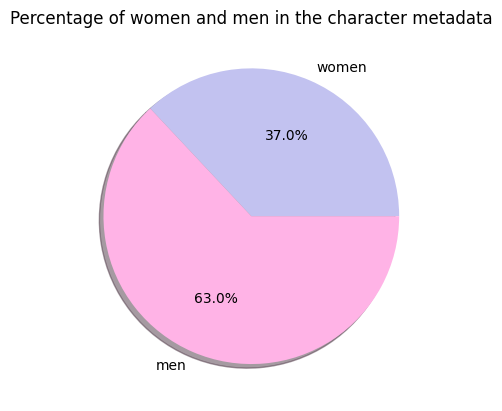

In [73]:
fem_act = character_metadata[character_metadata['Actor gender'] == 'F']
masc_act = character_metadata[character_metadata['Actor gender'] == 'M']
plt.pie(np.array([fem_act['Actor name'].nunique(),masc_act['Actor name'].nunique()]),labels=['women','men'],colors = ['#c2c2f0','#ffb3e6'],autopct='%1.1f%%',shadow=True)
plt.title('Percentage of women and men in the character metadata')
plt.show()

In [48]:
#replace NaN values with 0
character_metadata_clean = character_metadata.fillna(0)
movie_metadata_clean = movie_metadata.fillna(0)

In [60]:

#new dataframe with movies after 2007 after converting the release date to datetime some dates are only year so we need to add the month and day

movie_metadata_clean['Movie release date'] = pd.to_datetime(movie_metadata_clean['Movie release date'],errors='coerce')
movie_metadata_clean = movie_metadata_clean[movie_metadata_clean['Movie release date'] > datetime(2007,1,1)]
movie_metadata_clean.head()

,Freebase movie ID,Movie name,Movie release date,Movie box office revenue,Movie runtime,Movie languages,Movie countries,Movie genres
Wikipedia movie ID,,,,,,,,
21926710,/m/05p45cv,White on Rice,2009-01-01,0.0,82.0,{},"{""/m/09c7w0"": ""United States of America""}","{""/m/06cvj"": ""Romantic comedy"", ""/m/02l7c8"": ""..."
20604092,/m/0523t_1,Anbu Thozhi,2007-08-17,0.0,0.0,"{""/m/07c9s"": ""Tamil Language""}","{""/m/03rk0"": ""India""}","{""/m/02l7c8"": ""Romance Film""}"
29772142,/m/0fq260_,Karayilekku Oru Kadal Dooram,2010-12-31,0.0,110.0,"{""/m/0999q"": ""Malayalam Language""}","{""/m/03rk0"": ""India""}","{""/m/07s9rl0"": ""Drama""}"
26623942,/m/0bh9fbk,Kausthubham,2010-03-19,0.0,0.0,"{""/m/0999q"": ""Malayalam Language""}","{""/m/03rk0"": ""India""}","{""/m/07s9rl0"": ""Drama""}"
32445576,/m/0gyv1h1,Vinayaka Geleyara Balaga,2011-07-15,0.0,0.0,{},{},{}


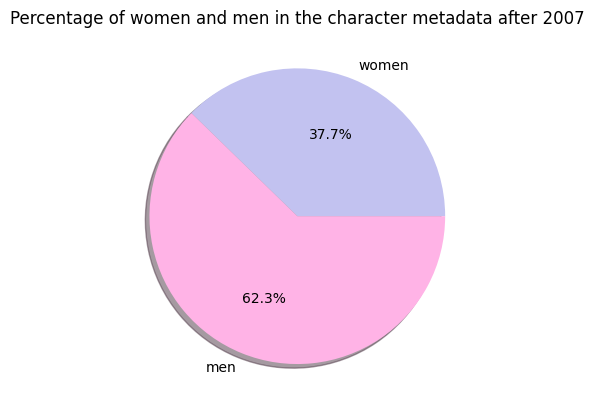

In [96]:
#only keep characters with 'wikipedia movie ID' in movie_metadata_clean after 2007
character_metadata_clean = character_metadata_clean[character_metadata_clean.index.isin(movie_metadata_clean.index)]
#number of female actors compared to male actors for movies after 2007 plotted in a pie chart
fem_act = character_metadata_clean[character_metadata_clean['Actor gender'] == 'F']
masc_act = character_metadata_clean[character_metadata_clean['Actor gender'] == 'M']
plt.pie(np.array([fem_act['Actor name'].nunique(),masc_act['Actor name'].nunique()]),labels=['women','men'],colors = ['#c2c2f0','#ffb3e6'],autopct='%1.1f%%',shadow=True)
plt.title('Percentage of women and men in the character metadata after 2007')
plt.show()




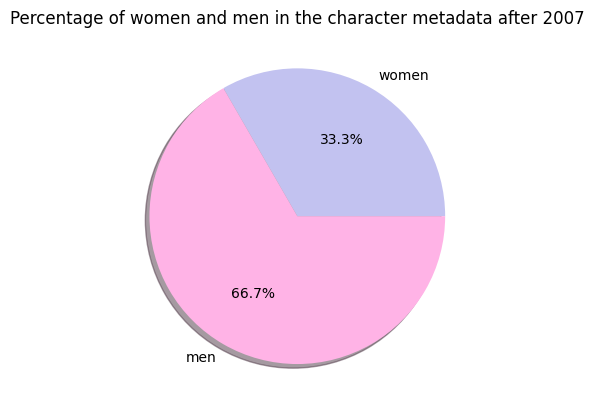

In [98]:
#new dataframe with movies after 2016 
movie_metadata_clean = movie_metadata_clean[movie_metadata_clean['Movie release date'] > datetime(2016,1,1)]
#only keep characters with 'wikipedia movie ID' in movie_metadata_clean after 2016
character_metadata_clean = character_metadata_clean[character_metadata_clean.index.isin(movie_metadata_clean.index)]
#number of female actors compared to male actors for movies after 2016 plotted in a pie chart
fem_act = character_metadata_clean[character_metadata_clean['Actor gender'] == 'F']
masc_act = character_metadata_clean[character_metadata_clean['Actor gender'] == 'M']
plt.pie(np.array([fem_act['Actor name'].nunique(),masc_act['Actor name'].nunique()]),labels=['women','men'],colors = ['#c2c2f0','#ffb3e6'],autopct='%1.1f%%',shadow=True)
plt.title('Percentage of women and men in the character metadata after 2016')
plt.show()




In [110]:
#analysing plot summaries to find main character is the one whose name is mentioned the most
#we will use the first 1000 characters of the plot summary to find the main character

#function to find the main character in a plot summary
def find_main_character(plot_summary):
    #create a list of all the characters in the plot summary
    characters = character_metadata_clean[character_metadata_clean.index == plot_summary.name]['Character name'].to_list()
    #create a list of the number of times each character is mentioned in the plot summary
    character_count = [plot_summary['Plot Summary'][:2000].count(character) for character in characters]
    #return the character with the highest number of mentions
    return characters[np.argmax(character_count)]   

#apply the function to the plot summaries
plot_summaries['Main character'] = plot_summaries.apply(find_main_character(plot_summaries),axis=1)
plot_summaries.head()

AttributeError: 'DataFrame' object has no attribute 'name'